# Numerical Variable Analysis

In [1]:
import pandas as pd
import plotly.express as ex
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from os.path import isfile
from tqdm import tqdm
import re

## Removing Duplicates

In [2]:
cases = [2, 3, 6, 7, 8, 9, 10]

In [3]:
def clean_data_columns(dataframe):
    dataframe_corrected = dataframe.drop(columns=[x for x in dataframe.columns if 'k_user' in x])

    dataframe_corrected = dataframe_corrected.rename(columns={"predictedValue": "point_value",
                                                              "Metric:": "metric",
                                                              "Case:": "case",
                                                              "Depth:": "depth",
                                                              "Energy:": "energy",
                                                              "Energy_FFF :": "energy_fff",
                                                              "Gantry:": "gantry",
                                                              "Mode:": "mode",
                                                              "Au date": "date",
                                                              "Point type": "point_type"})

    columns_to_keep = [x for x in dataframe_corrected.columns if "k_user" not in x]
    dataframe_corrected = dataframe_corrected[columns_to_keep]

    dataframe_corrected = dataframe_corrected[
        dataframe_corrected['point_type'].isin(['Prescription Point', 'Worst Point +ve', 'Worst Point -ve'])]
    dataframe_corrected = dataframe_corrected[dataframe_corrected['case'].isin(cases)]
    dataframe_corrected.columns = [x.lower() for x in dataframe_corrected.columns]

    missing_date = dataframe_corrected.iloc[11571]['date']
    dataframe_corrected["date"].fillna(missing_date, inplace=True)

    dataframe_corrected = dataframe_corrected[dataframe_corrected['manuf'] != "Wavy Welsh Corgi"]

    return dataframe_corrected

In [5]:
df = pd.read_csv("Cleansing the data/Clean_data.csv", low_memory=False)
data = clean_data_columns(df)

In [6]:
# data_last1 = data[data['new_audit_id'].apply(lambda x: True if int(x[-1])==1 else False)]
# data_last2 = data[data['new_audit_id'].apply(lambda x: True if int(x[-1])==2 else False)]
# data_last3 = data[data['new_audit_id'].apply(lambda x: True if int(x[-1])==3 else False)]
# data_last4 = data[data['new_audit_id'].apply(lambda x: True if int(x[-1])==4 else False)]

In [7]:
# import warnings
# warnings.filterwarnings('ignore')

In [10]:
def remove_duplicates(dataframe):
    """
    Cascade all the updated values onto the old values
    For predicted_id "467035_2_PxVar|2|10|6|0|0|1" in dataframe, finds predicted_id ""467035_1_PxVar|2|10|6|0|0|1"" in
    and replaces the point_value of the main dataframe with those from updated_dataframe
    :param dataframe: Dataframe that contains all the data
    :return: Updated dataframe without any duplicate values
    """

    def convert_date(x):
        x = str(x)

        date_format = "%Y-%m-%d"
        return datetime.strptime(x, date_format)

    dataframe_main = dataframe[
        dataframe['new_audit_id'].apply(lambda x: True if int(x[-1]) == 1 else False)].reset_index(drop=True)
    dataframe_updates = dataframe[
        dataframe['new_audit_id'].apply(lambda x: True if int(x[-1]) != 1 else False)].reset_index(drop=True)

    # id_remove_main = []
    id_remove_update = []

    print("Preliminary diagnostics")
    print(f"main_dataframe shape: {dataframe_main.shape}")
    print(f"updated_dataframe shape: {dataframe_updates.shape}", end="\n\n")

    for index, row in tqdm(dataframe_main.iterrows()):

        main_date = convert_date(row['date'])

        predicted_id_2 = re.sub(r"_(\d)_", "_2_", row['predicted_id'])
        predicted_id_3 = re.sub(r"_(\d)_", "_3_", row['predicted_id'])
        predicted_id_4 = re.sub(r"_(\d)_", "_4_", row['predicted_id'])

        row_revised_2 = dataframe_updates.loc[dataframe_updates["predicted_id"] == predicted_id_2]
        row_revised_3 = dataframe_updates.loc[dataframe_updates["predicted_id"] == predicted_id_3]
        row_revised_4 = dataframe_updates.loc[dataframe_updates["predicted_id"] == predicted_id_4]

        # Drop from updates
        if len(row_revised_2) != 0:
            revised_2_date = convert_date(row_revised_2['date'].iloc[0])
            if (revised_2_date - main_date).days < 365:
                id_remove_update.append(row_revised_2.index[0])

        if len(row_revised_3) != 0:
            revised_3_date = convert_date(row_revised_3['date'].iloc[0])
            if (revised_3_date - main_date).days < 365:
                id_remove_update.append(row_revised_3.index[0])

        if len(row_revised_4) != 0:
            revised_4_date = convert_date(row_revised_4['date'].iloc[0])
            if (revised_4_date - main_date).days < 365:
                id_remove_update.append(row_revised_4.index[0])

        # Add new to main and drop original from main
        if len(row_revised_4) != 0:
            if (revised_4_date - main_date).days < 365:
                dataframe_main.loc[index, 'point_value'] = row_revised_4['point_value'].iloc[0]
                dataframe_main.loc[index, 'predicted_id'] = row_revised_4['predicted_id'].iloc[0]
                # id_remove_main.append(index)

        elif len(row_revised_3) != 0:
            if (revised_3_date - main_date).days < 365:
                dataframe_main.loc[index, 'point_value'] = row_revised_3['point_value'].iloc[0]
                dataframe_main.loc[index, 'predicted_id'] = row_revised_3['predicted_id'].iloc[0]
                # id_remove_main.append(index)
        elif len(row_revised_2) != 0:
            if (revised_2_date - main_date).days < 365:
                dataframe_main.loc[index, 'point_value'] = row_revised_2['point_value'].iloc[0]
                dataframe_main.loc[index, 'predicted_id'] = row_revised_2['predicted_id'].iloc[0]
                # id_remove_main.append(index)

    main_updated = dataframe_main
    updates_updated = dataframe_updates.drop(id_remove_update)
    dataframe_merged = pd.concat([main_updated, updates_updated], axis=0)

    print("\nConcluding diagnostics")
    print(f"main_updated shape: {main_updated.shape}")
    print(f"updated_dataframe shape: {updates_updated.shape}")
    print(f"dataframe_merged shape: {dataframe_merged.shape}", end="\n\n")

    return dataframe_merged

In [11]:
data_no_duplicates = remove_duplicates(data)

Preliminary diagnostics
main_dataframe shape: (11510, 44)
updated_dataframe shape: (6178, 44)



11510it [00:15, 756.11it/s]


Concluding diagnostics
main_updated shape: (11510, 44)
updated_dataframe shape: (404, 44)
dataframe_merged shape: (11914, 44)



In [12]:
# data_last3_updated, data_last4_updated = replace_value_and_drop(data_last3, data_last4)
# data_last2_updated, data_last3_updated = replace_value_and_drop(data_last2, data_last3_updated)
# data_last1_updated, data_last2_updated = replace_value_and_drop(data_last1, data_last2_updated)

In [13]:
# def replace_value_and_drop(dataframe):
#     """
#     Cascade all the updated values onto the old values
#     For predicted_id "467035_2_PxVar|2|10|6|0|0|1" in dataframe, finds predicted_id ""467035_1_PxVar|2|10|6|0|0|1"" in
#     and replaces the point_value of the main dataframe with those from updated_dataframe
#     :param dataframe: Dataframe that contains all the data
#     :return: Updated dataframe without any duplicate values
#     """

#     def convert_date(x):
#         x = str(x)

#         date_format = "%Y-%m-%d"
#         return datetime.strptime(x, date_format)

#     dataframe_main = dataframe[dataframe['new_audit_id'].apply(lambda x: True if int(x[-1]) == 1 else False)].reset_index(drop = True)
#     dataframe_updates = dataframe[dataframe['new_audit_id'].apply(lambda x: True if int(x[-1]) != 1 else False)].reset_index(drop = True)

#     # id_remove_main = []
#     id_remove_update = []

#     print("Preliminary diagnostics")
#     print(f"main_dataframe shape: {dataframe_main.shape}")
#     print(f"updated_dataframe shape: {dataframe_updates.shape}", end="\n\n")

#     for index, row in tqdm(dataframe_main.iterrows()):

#         main_date = convert_date(row['date'])

#         predicted_id_2 = re.sub(r"_(\d)_", "_2_", row['predicted_id'])
#         predicted_id_3 = re.sub(r"_(\d)_", "_3_", row['predicted_id'])
#         predicted_id_4 = re.sub(r"_(\d)_", "_4_", row['predicted_id'])

#         row_revised_2 = dataframe_updates.loc[dataframe_updates["predicted_id"] == predicted_id_2]
#         row_revised_3 = dataframe_updates.loc[dataframe_updates["predicted_id"] == predicted_id_3]
#         row_revised_4 = dataframe_updates.loc[dataframe_updates["predicted_id"] == predicted_id_4]

#         # Drop from updates
#         if len(row_revised_2) != 0:
#             revised_2_date = convert_date(row_revised_2['date'].iloc[0])
#             if (revised_2_date - main_date).days < 365:
#                 id_remove_update.append(row_revised_2.index[0])

#         if len(row_revised_3) != 0:
#             revised_3_date = convert_date(row_revised_3['date'].iloc[0])
#             if (revised_3_date - main_date).days < 365:
#                 id_remove_update.append(row_revised_3.index[0])

#         if len(row_revised_4) != 0:
#             revised_4_date = convert_date(row_revised_4['date'].iloc[0])
#             if (revised_4_date - main_date).days < 365:
#                 id_remove_update.append(row_revised_4.index[0])

#         # Add new to main and drop original from main
#         if len(row_revised_4) != 0:
#             if (revised_4_date - main_date).days < 365:
#                 dataframe_main.loc[index, 'point_value'] = row_revised_4['point_value'].iloc[0]
#                 dataframe_main.loc[index, 'predicted_id'] = row_revised_4['predicted_id'].iloc[0]
#                 # id_remove_main.append(index)

#         elif len(row_revised_3) != 0:
#             if (revised_3_date - main_date).days < 365:
#                 dataframe_main.loc[index, 'point_value'] = row_revised_3['point_value'].iloc[0]
#                 dataframe_main.loc[index, 'predicted_id'] = row_revised_3['predicted_id'].iloc[0]
#                 # id_remove_main.append(index)
#         elif len(row_revised_2) != 0:
#             if (revised_2_date - main_date).days < 365:
#                 dataframe_main.loc[index, 'point_value'] = row_revised_2['point_value'].iloc[0]
#                 dataframe_main.loc[index, 'predicted_id'] = row_revised_2['predicted_id'].iloc[0]
#                 # id_remove_main.append(index)

#     main_updated = dataframe_main
#     updates_updated = dataframe_updates.drop(id_remove_update)
#     dataframe_merged = pd.concat([main_updated, updates_updated], axis=0)

#     print("\nConcluding diagnostics")
#     print(f"main_updated shape: {main_updated.shape},== {dataframe_main.shape}")
#     print(f"updated_dataframe shape: {updates_updated.shape}=={dataframe_updates.shape}")
#     print(f"dataframe_merged shape: {dataframe_merged.shape}", end="\n\n")

#     print(f"main_updated:{main_updated['audit_id'].nunique()},"
#           f"updates_updated:{updates_updated['audit_id'].nunique()},"
#           f"dataframe_merged:{dataframe_merged['audit_id'].nunique()}")

#     return dataframe_merged

# merged_df = replace_value_and_drop(data)

In [14]:
# # SAVE TO EXCEL AND CSV FILES
# data_merged.to_csv("Cleansing the data/No_Duplicates.csv", index = False)
# data_merged.to_excel("Cleansing the data/No_Duplicates.xlsx", index = False)

# Creating datasets per case

In [15]:
# columns_to_keep = [x for x in all_data.columns if "k_user" not in x]
# needed_point_types = ["Prescription Point","Worst Point +ve","Worst Point -ve"]

# df_updated = all_data[columns_to_keep]
# df_updated = temp[temp["point_type"].isin(needed_point_types)]

In [16]:
def create_per_case_datafiles(dataframe):
    for case in cases:
        temp_df = dataframe[dataframe["case"] == case].reset_index(drop=True)
        
        excel_file_name = "Cleansing the data\Datasets by Case\Excel\case_" + str(case) + ".xlsx"
        csv_file_name = "Cleansing the data\Datasets by Case\CSV\case_" + str(case) + ".csv"

        temp_df.to_excel(excel_file_name, index=False)
        temp_df.to_csv(csv_file_name, index=False)

In [17]:
create_per_case_datafiles(data_no_duplicates)

# Correcting for case 3

In [33]:
def add_corrected_point_value(reference_data, target_data):
    """
    Correcting point_values for ALL POINT TYPES, and ALL DEPTHS using corresponding prescription point value of case 3
    """

    # target_data["corrected_point_value"] = None
    current_case = target_data["case"].iloc[0]
    errors = False
    print(f"Correcting for case:{current_case}")
    
    for index, row in target_data.iterrows():
        current_id = row["audit_id"]
        current_point_type = row["point_type"]
        current_energy = row["energy"]
        current_fff = row["energy_fff"]
        current_date = row["date"]
        current_point_value = row["point_value"]

        try:
            c3_reference_value = reference_data["point_value"][(reference_data["audit_id"] == current_id) &
                                                               (reference_data["point_type"] == "Prescription Point") &
                                                               (reference_data["energy"] == current_energy) &
                                                               (reference_data["energy_fff"] == current_fff) &
                                                               (reference_data["case"] == 3) &
                                                               (reference_data["depth"] == 10) &
                                                               (reference_data["date"] == current_date)].iloc[0]
        except IndexError:
            errors = True
            print(f"For audit_id {current_id}:")
            if current_id not in reference_data["audit_id"].values:
                print(f"{current_id} not in reference data")

            if current_point_type not in reference_data["point_type"]:
                print(f"{current_point_type} not in reference_data")

            if current_energy not in reference_data["energy"].values:
                print(f"Energy:{current_energy} not in reference data")

            if current_fff not in reference_data["energy_fff"].values:
                print(f"fff:{current_fff} not in reference data")

            if 10 not in reference_data["depth"].values:
                print(f"Depth 10 not in reference data")

            if current_date not in reference_data["date"].values:
                print(f"Date:{current_date} not in reference data")

            print("Error")
            continue

        corrected_point_value = ((current_point_value + 1) / (c3_reference_value + 1)) - 1
        target_data.loc[index, "corrected_point_value"] = corrected_point_value
    if not errors:
        print("No Errors")

    return target_data

In [39]:
def create_and_save_corrected_values():
    case3_data = pd.read_csv("Cleansing the data/Datasets by Case/CSV/case_3.csv") 
    merged_data = pd.DataFrame()

    for case in cases:
        csv_file_name = "Cleansing the data/Datasets by Case/CSV/case_" + str(case) + ".csv"
        casex_data = pd.read_csv(csv_file_name)

        corrected_data = add_corrected_point_value(case3_data, casex_data)
        corrected_data.to_csv(f"Cleansing the data/Datasets by Case/Case3_Corrected/case_{case}_corrected.csv", index=False)

        merged_data = pd.concat([merged_data, corrected_data], axis=0)

    merged_data.to_csv("Cleansing the data/FINAL_DATA.csv", index=False)
    return merged_data

In [42]:
final_data = create_and_save_corrected_values()

Correcting for case:2
No Errors
Correcting for case:3
No Errors
Correcting for case:6
No Errors
Correcting for case:7
No Errors
Correcting for case:8
No Errors
Correcting for case:9
No Errors
Correcting for case:10
No Errors


# Numerical Analysis

In [44]:
data = pd.read_csv("Cleansing the data/FINAL_DATA.csv", low_memory=False)
# data = pd.read_csv("Cleansing the data/Clean_data.csv", low_memory=False)

In [45]:
data.columns

Index(['predicted_id', 'new_audit_id', 'audit_id', 'facility_id', 'status',
       'auditor1', 'auditor2', 'auditor3', 'date', 'manuf', 'model', 'tps',
       'algorithm', 'matched', 'k_q fac.', 'k_q acds', 'array', 's.n.',
       'audit', '6_daily_output', '10_daily_output', '15_daily_output',
       '18_daily_output', '6fff_daily_output', '10fff_daily_output',
       '6__tpr_20,10', '10__tpr_20,10', '15__tpr_20,10', '18__tpr_20,10',
       '6fff__tpr_20,10', '10fff__tpr_20,10', 'version', 'corr.', 'alg.',
       'rev.', 'metric', 'case', 'depth', 'energy', 'energy_fff', 'gantry',
       'mode', 'point_type', 'point_value', 'corrected_point_value'],
      dtype='object')

In [46]:
df = data[data["metric"]=="PxVar"]

In [47]:
df.dtypes.value_counts()

object     19
float64    18
int64       8
dtype: int64

In [48]:
non_category_columns = [x for x in df.columns if df[x].dtypes != 'O']
# non_category_columns.remove('Au date')

date_column = [x for x in df.columns if df[x].dtypes == "datetime64[ns]"] 

columns_to_remove = [x for x in non_category_columns if df[x].value_counts().count() < 8]
columns_to_remove.remove('15_daily_output')
columns_to_remove.remove('15__tpr_20,10')
columns_to_remove.append('audit_id')
columns_to_remove.append('case')

numerical_columns = [x for x in non_category_columns if x not in columns_to_remove]
numerical_columns

['6_daily_output',
 '10_daily_output',
 '15_daily_output',
 '18_daily_output',
 '6fff_daily_output',
 '10fff_daily_output',
 '6__tpr_20,10',
 '10__tpr_20,10',
 '15__tpr_20,10',
 '18__tpr_20,10',
 '6fff__tpr_20,10',
 '10fff__tpr_20,10',
 'point_value',
 'corrected_point_value']

## Missing values in each column

In [49]:
# missing_count = df[numerical_columns].isna().sum()
# missing_count = missing_count.sort_values(ascending = False)

# missing_percent = (df[numerical_columns].isna().sum() / df[numerical_columns].shape[0]) * 100
# missing_percent = missing_percent.sort_values(ascending = False)

In [50]:
# sns.set(rc={'figure.figsize':(15,8)})

# ax = sns.barplot(y = missing_percent.index, x = missing_percent.values, orient='h')
# ax.set(xlabel="Percentage of Mising Values", yticklabels=missing_percent.index)
# ax.set_title("Missing Data (%)", size = 20)
# sns.set_theme(style = "white")
# for i in ax.containers:
#     ax.bar_label(i,)

# # plt.savefig("Figures/Missing Data.png")
# plt.show()

In [51]:
# # Columns with more than 35% missing values
# numerical_columns =  [name for name, value in zip(missing_percent.index, missing_percent.values) if value <= 35]

In [52]:
# print(f"Total number of features to be included in the numerical analysis: {len(numerical_columns)}\n")
# for col in df[numerical_columns].columns:
#     print(col)

## Distributions of each feature

In [53]:
# num_filled_cells = len(numerical_columns)-1 #7
# for i in range(num_filled_cells):
#     sns.set(rc={'figure.figsize':(10,2)})
#     sns.set_style("white")
#     sns.histplot(df[numerical_columns[i]], color = "C0", kde = True)
#     file_name = "Histogram--" + str(numerical_columns[i])
#     # plt.savefig("Figures/Histograms/"+file_name)
#     plt.show()

In [54]:
# # rows = 7
# # cols = 3

# rows = 3
# cols = 3
# num_filled_cells = len(numerical_columns)-1 #7

# fig, ax = plt.subplots(ncols = cols, nrows=rows, squeeze= False, figsize = (30,16))
# fig.tight_layout(pad=2)
# for i in range(num_filled_cells):
#     row = i//cols
#     col = i%cols
#     sns.histplot(df[numerical_columns[i]], ax = ax[row, col], color = "C0")
    
# fig.suptitle("Distributions of Numerical Features")
    
# ax[2,2].set_axis_off()
# ax[2,1].set_axis_off()

# plt.savefig("Figures/Distributions of Numerical Features.png")
# plt.show()

## Ranges and Potential Outliers

In [55]:
# cols = sns.color_palette("Spectral",8)
# cols

In [56]:
# sns.set(rc={'figure.figsize':(2,10)})
# sns.set_style("whitegrid")

# for i in range(len(numerical_columns[:-1])):
#     print(i)

#     p = sns.boxplot(df[numerical_columns[i]], color=cols[i],orient='v')
    
#     ylab_text = p.get_yticklabels()
                 
#     ylab_min = ylab_text[0].get_text()
#     ylab_min_pos = ylab_text[0].get_position()[1]
#     ylab_max = ylab_text[-1].get_text()
#     ylab_max_pos = ylab_text[-1].get_position()[1]
    
#     ylab_range = float(ylab_max) - float(ylab_min)
    
#     texts = [x.get_text() for x in ylab_text][1:-1]
#     positions = [x.get_position()[1] for x in ylab_text][1:-1]
    
#     p.set(xlabel=numerical_columns[i])
#     p.set(xticklabels="")
#     p.set(yticklabels="")
#     for j in range(len(positions)):
#         p.text(-0.1,positions[j], texts[j])
    
#     # p.text(-0.1,ylab_min_pos + 0.029*(ylab_range), ylab_min)
#     # p.text(-0.1, ylab_max_pos - 0.035 * (ylab_range) ,ylab_max)
    
#     file_name = "Boxplot--" + str(numerical_columns[i])
#     print(file_name)
#     # plt.savefig("Figures/Boxplots/" + file_name)
#     plt.show()

In [57]:
# fig, ax = plt.subplots(nrows=2, ncols=4, squeeze= True, figsize = (10,10))
# fig.suptitle("Boxplots of Features", fontsize = 16)
# fig.tight_layout(w_pad=2, h_pad=1)

# for i in range(len(numerical_columns[:-1])):
#     row = i//4
#     column = i%4
#     p = sns.boxplot(df[numerical_columns[i]], ax = ax[row,column], color=cols[i])
#     p.set(xlabel=numerical_columns[i])
#     p.set(xticklabels="")
    
# ax[1,3].set_axis_off()
# # ax[2,1].set_axis_off()

# plt.savefig("Figures/Boxplots/All Boxplots of Features.png")
# plt.show()

## Heatmap of numerical data

In [58]:
# corr_data = df[numerical_columns[:-1]].corrwith(df["point_value"]).sort_values()

# fig, ax = plt.subplots(figsize = (6,3))
# sns.barplot(y = corr_data.index,  x = corr_data.values, orient='h', palette='rocket', ax = ax)

# plt.title("Correlation of Numerical Features with 'point_value' ", fontsize = 16)

# # ax.set_ylabel(" ",labelpad=30)


# # plt.savefig("Figures/Correlation of each of the numerical features.png", bbox_inches='tight')
# plt.show()

In [59]:
# fig, ax = plt.subplots(figsize=(6,5))         # Sample figsize in inches

# sns.heatmap(df[numerical_columns].corr(),linewidths=0.5, linecolor='black', ax=ax, center = 0.4, cmap = ("Set2"))
# plt.title("Correlation of Numerical Features with One-another", size = 16)

# # plt.savefig("Figures/Correlation Numerical Features with one another.png",bbox_inches='tight')
# plt.show()

In [60]:
# per_case_manuf_values = df[["manuf","point_value","case"]].groupby(["case","manuf"]).median()

In [61]:
# dfs = []
# for case, new_df in per_case_manuf_values.groupby(level=0):
#     dfs.append(new_df)

# sns.set(rc={'figure.figsize':(5,4)})
# sns.set_style("whitegrid")

# for index, data in enumerate(dfs):
#     case = data.reset_index()["case"][0]
    
#     clean_df = data.reset_index().drop(columns = 'case')
#     manuf = clean_df["manuf"].values
    
#     plot = sns.barplot(data = clean_df, x = "manuf", y = "point_value")
#     plt.title(f"case {case}")
#     plot.tick_params(labelrotation=15)
#     plot.set_title(f"case {case}", size = 16)
    
#     plot.bar_label(plot.containers[0])
    
#     plot.set_ylabel("Median of predicted value")
    
#     if len(str(case)) == 1:
#         case = "0" + str(case)
    
#     file_name = "Case " + str(case)
#     print(file_name)
#     # plt.savefig("Figures/manuf by Case/" + file_name, bbox_inches='tight')
#     plt.show()

In [62]:
# dfs = []
# for case, new_df in per_case_manuf_values.groupby(level=0):
#     dfs.append(new_df)
    
# fig, ax = plt.subplots(ncols = 4, nrows = 4, figsize = (20,20))

# for index, data in enumerate(dfs):
#     case = data.reset_index()["case"][0]
    
#     clean_df = data.reset_index().drop(columns = 'case')
#     manuf = clean_df["manuf"].values
    
#     col = index%4
#     row = index//4
    
#     plot = sns.barplot(data = clean_df, x = "manuf", y = "point_value", ax = ax[row, col])
#     plt.title(f"case {case}")
#     ax[row,col].tick_params(labelrotation=15)
#     ax[row,col].set_title(f"case {case}", size = 16)
    
#     ax[row,col].bar_label(plot.containers[0])
    
#     ax[row,col].set_ylabel("Median of predicted value")

# fig.suptitle("Comparing Manufactureres by Case", size = 20)
# fig.tight_layout(pad=2)

# plt.savefig("Figures/Comparing_Manufacturers_by_Case.png")
# plt.show()

## Analysing Manufacturer - Algorithm data
### Every case and every point type

In [63]:
# # For every point
# for point_type in data["point_type"].value_counts().keys():
#     for case in cases:
#         file_path = "Datasets by Case/CSV/Case_" + str(case) + ".csv"
#         df_caseX = pd.read_csv(file_path)
#         df_caseX_pp = df_caseX[["manuf","algorithm","point_type","point_value"]][df_caseX["point_type"] == point_type]
#         df_caseX_pp["point_value%"] = df_caseX_pp["point_value"] * 100

#         hmap = sns.heatmap(pd.pivot_table(df_caseX_pp,
#                                           index='algorithm',
#                                           columns='manuf', 
#                                           values='point_value%'),
#                           annot = True,
#                           linewidths=0.5, 
#                           linecolor='black')
        
#         for t in hmap.texts: t.set_text(t.get_text() + " %")
#         hmap.set_title("CASE " + str(case) + ": " + str(point_type) + " (Mean)")
#         plt.xticks(rotation = 15)
        
#         path = "Figures/Algo_manuf_mean/Heatmaps/"+str(point_type)+"/Case_" + str(case) + ".png"
        
#         if not isfile(path):
#             plt.savefig(path, bbox_inches='tight')
#             print("Figure Saved!")
            
#         plt.show()

In [64]:
# from pathlib import Path
# sns.set_style("whitegrid")
# # For every point
# for point_type in data["point_type"].value_counts().keys():
#     for case in cases:
#         file_path = "Datasets by Case/CSV/Case_" + str(case) + ".csv"
#         df_caseX = pd.read_csv(file_path)
#         df_caseX_pp = df_caseX[["manuf","algorithm","point_type","point_value"]][df_caseX["point_type"] == point_type]
#         df_caseX_pp["point_value%"] = df_caseX_pp["point_value"] * 100

#         pd.pivot_table(df_caseX_pp,
#                       index='algorithm',
#                       columns='manuf', 
#                       values='point_value%').plot.barh(figsize=(10,7), title = "CASE " + str(case) + ": " + str(point_type) + " (Mean)")

#         plt.legend()
        
#         path = "Figures/Algo_Manuf_mean/HBar Graphs/"+str(point_type)+"/Case_" + str(case) + ".png"
#         if not Path(path).is_file():
#             plt.savefig(path, bbox_inches='tight')
#             print("Figure Saved!")
            
#         plt.show()

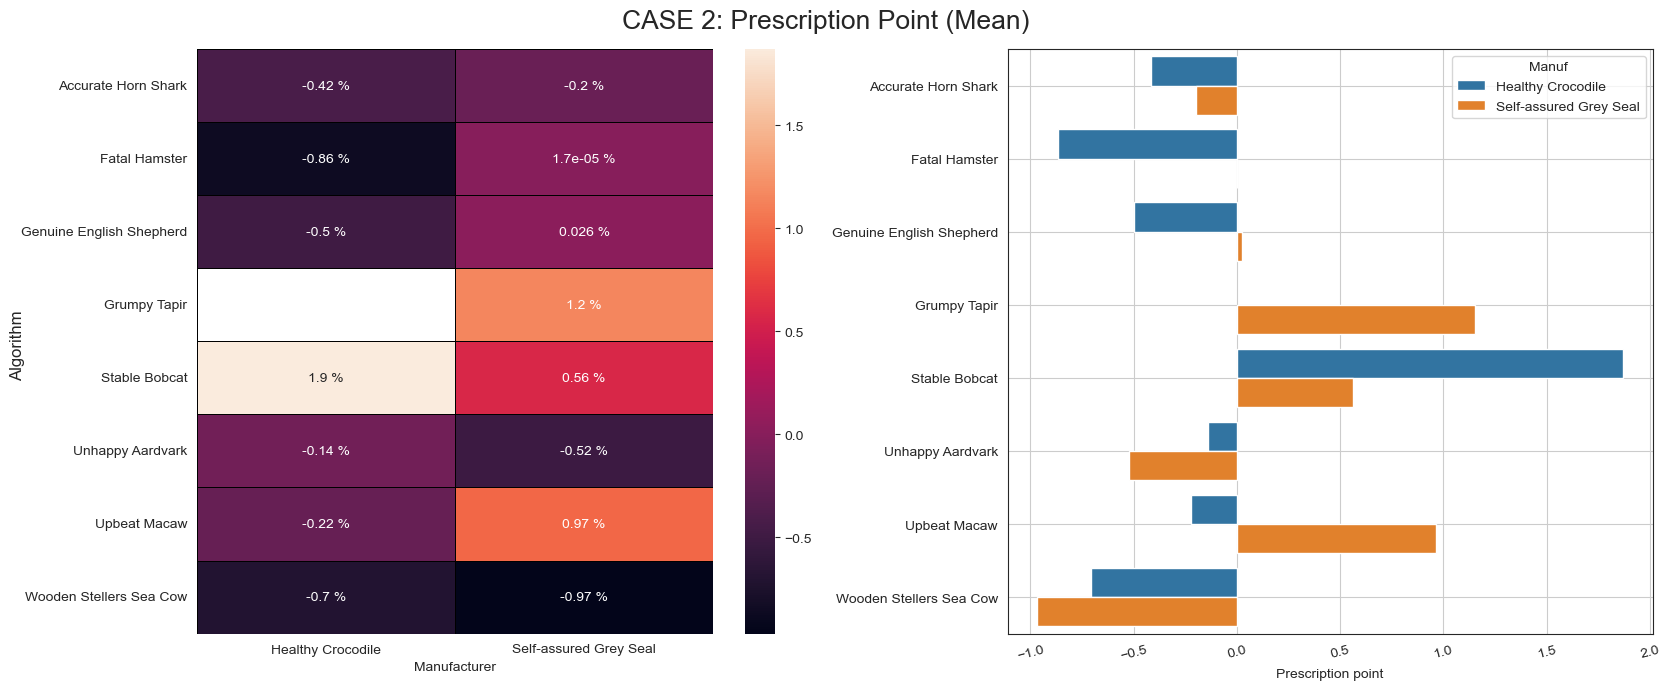

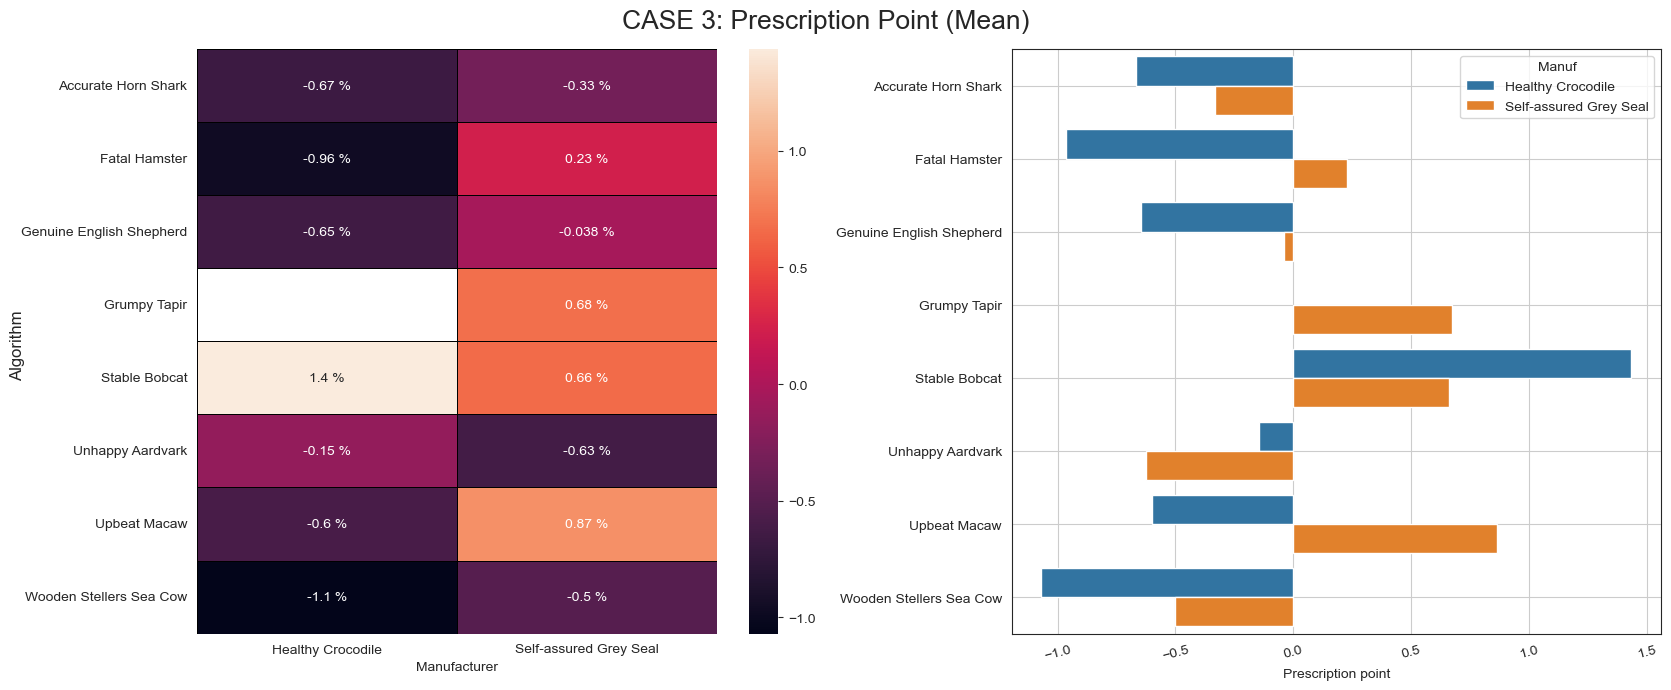

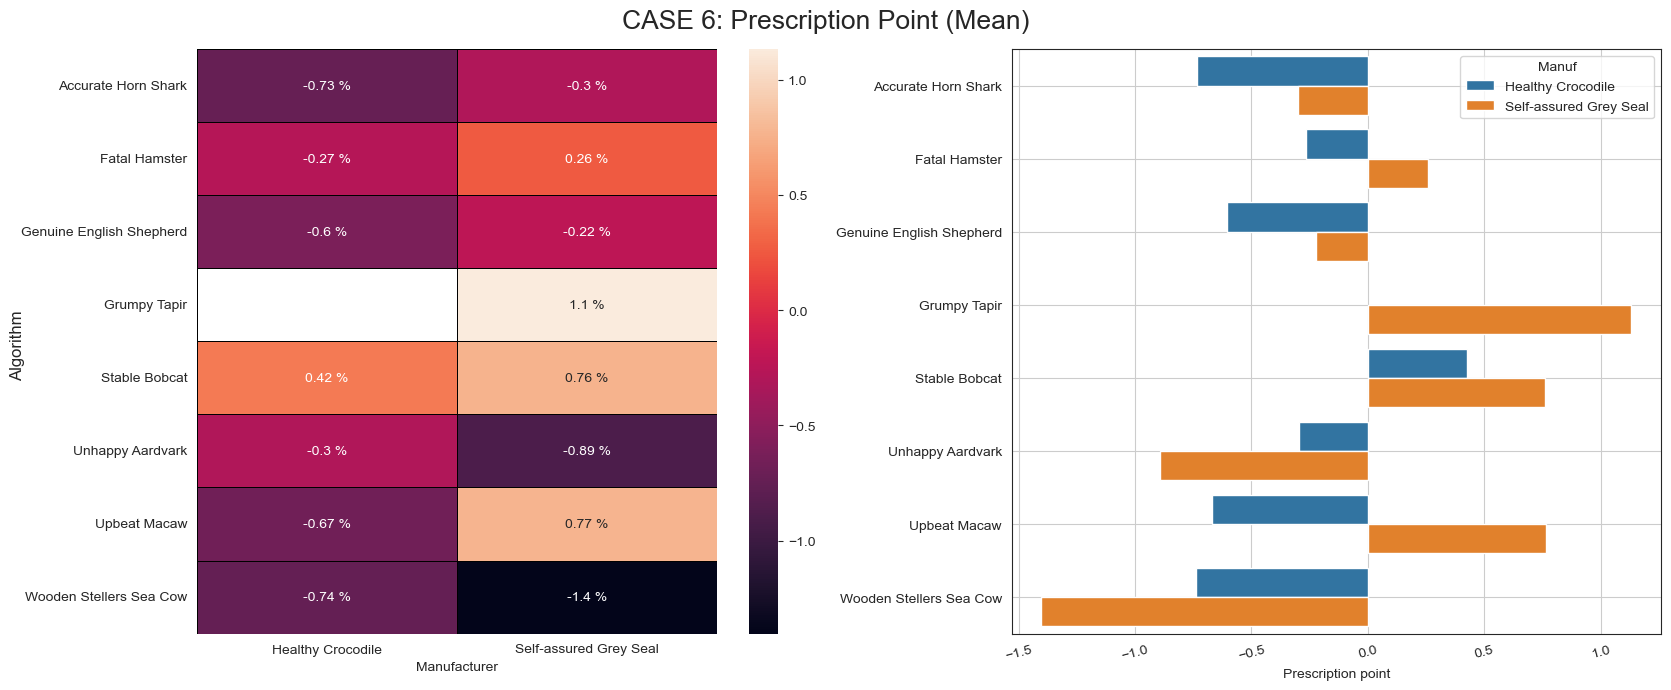

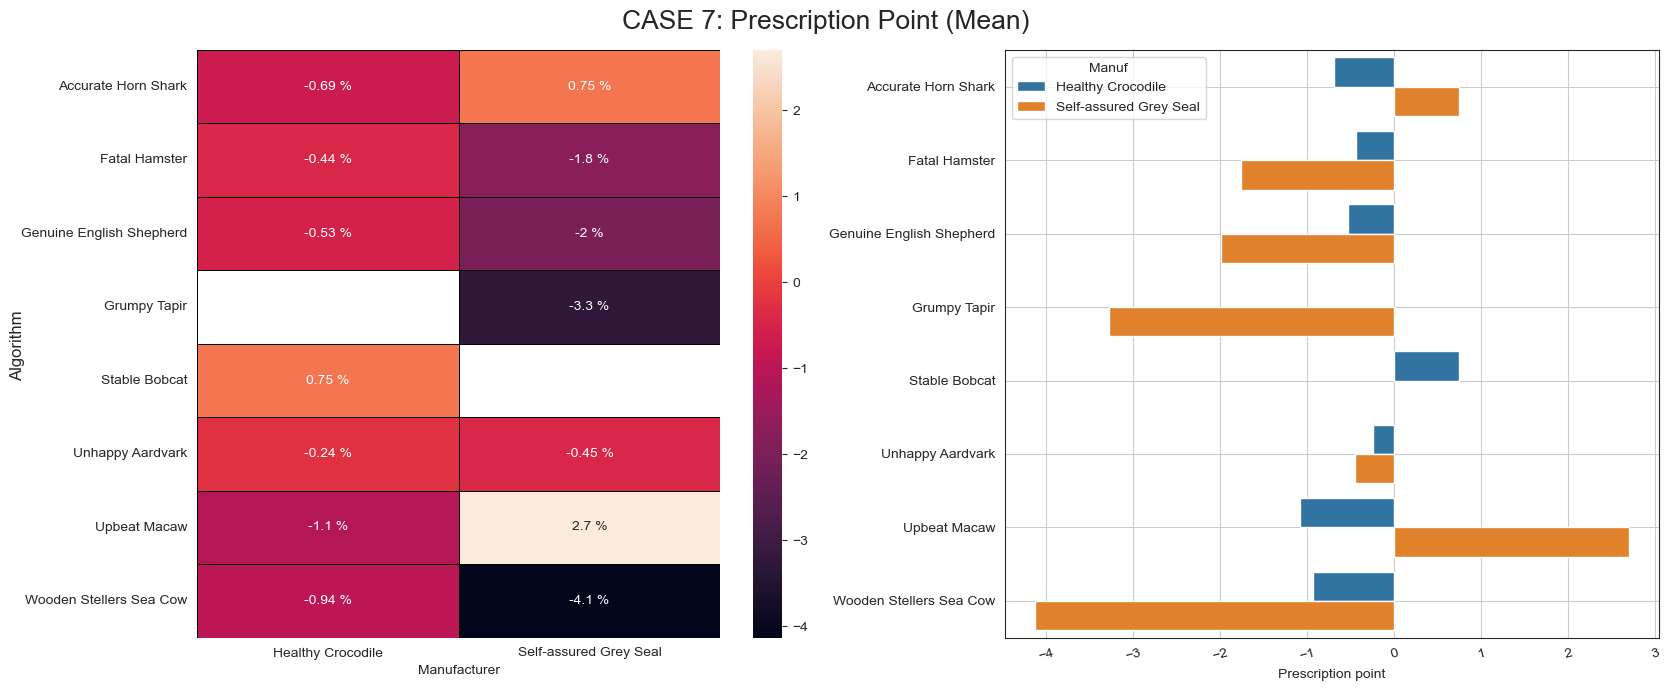

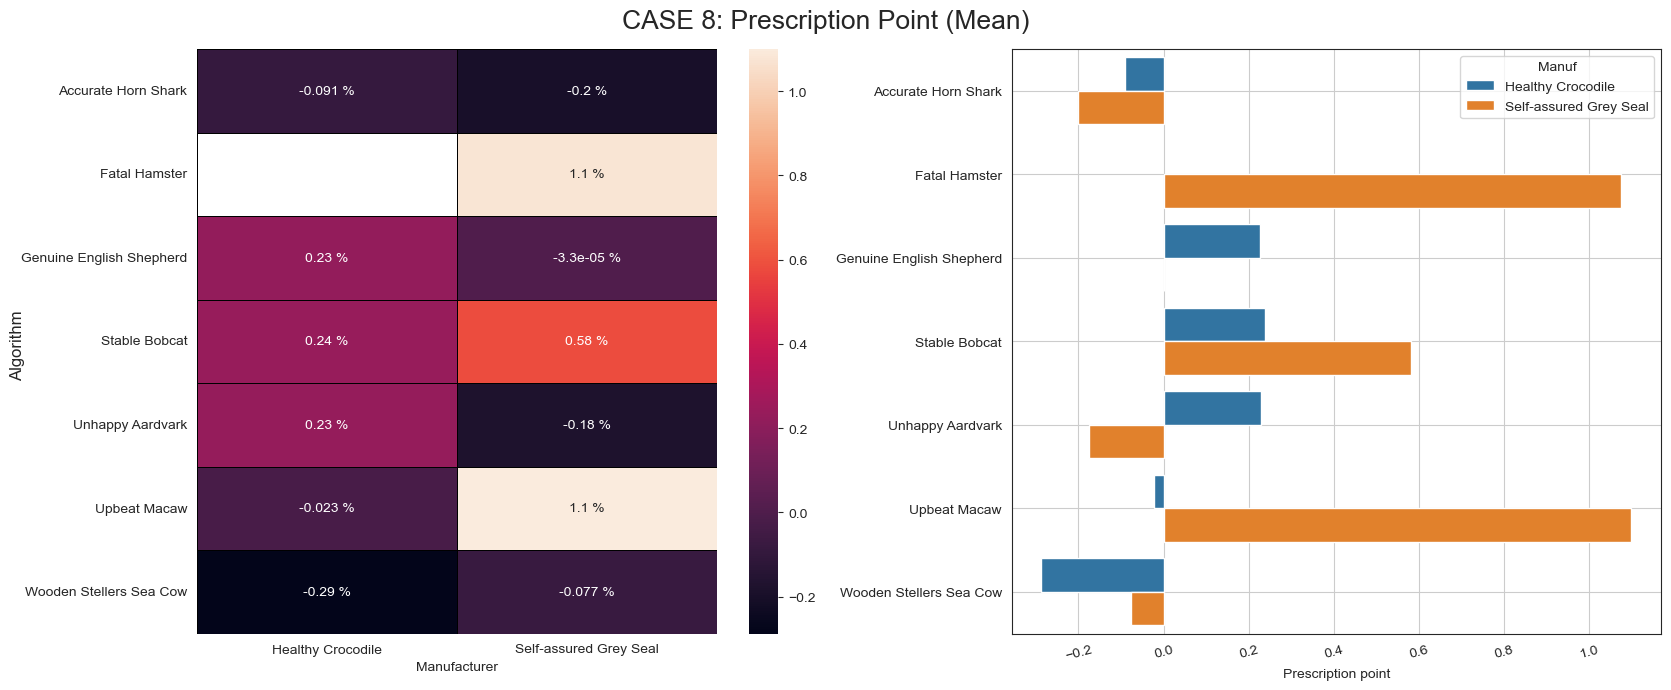

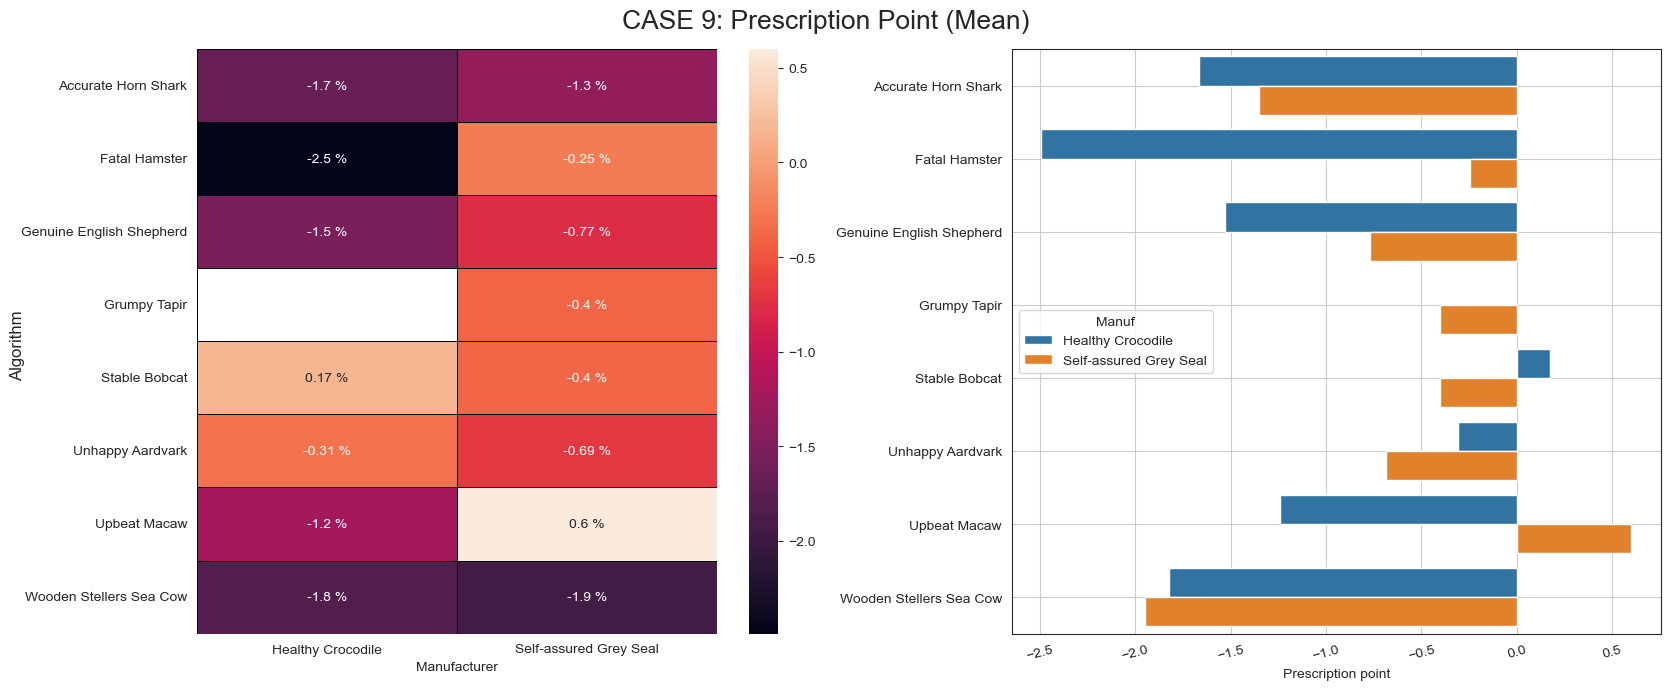

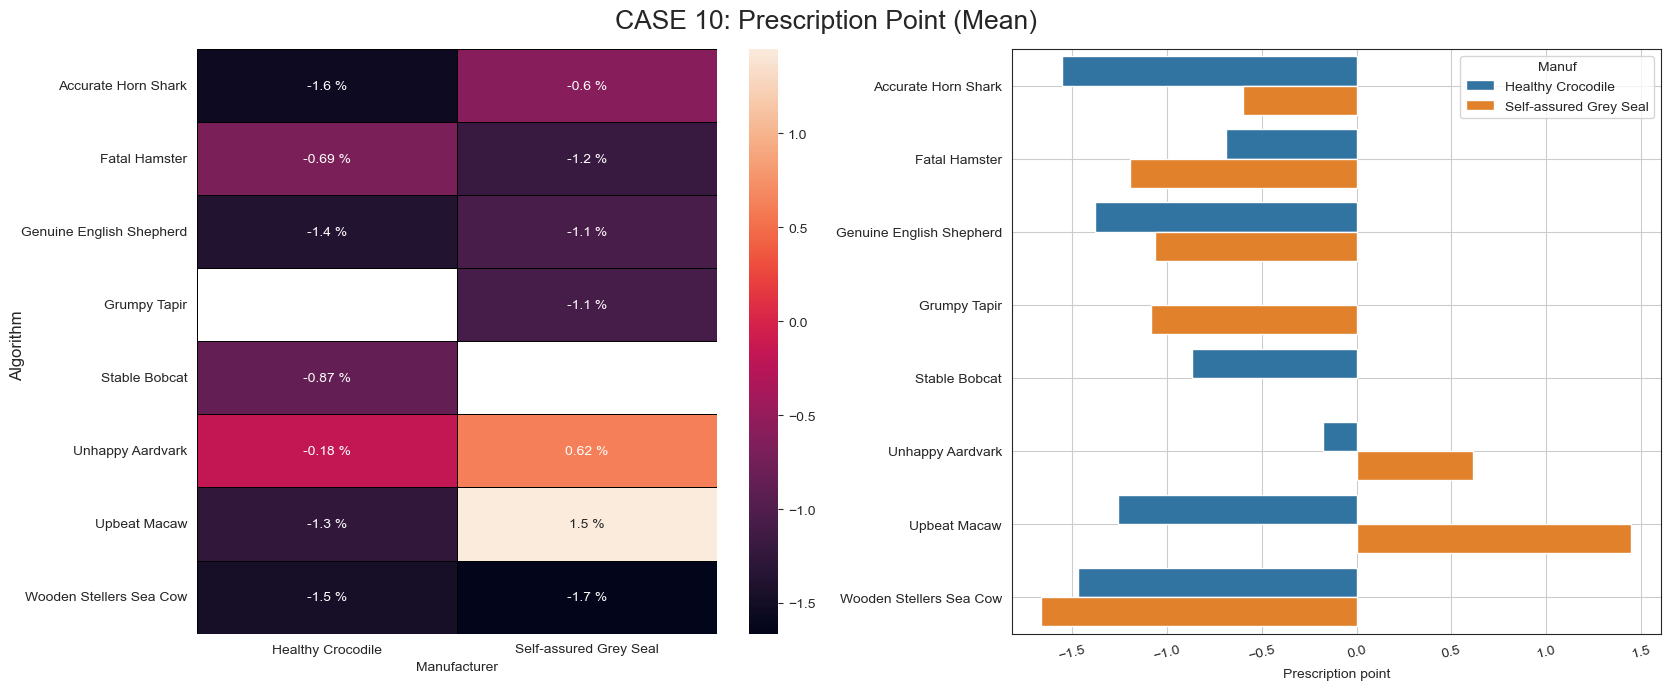

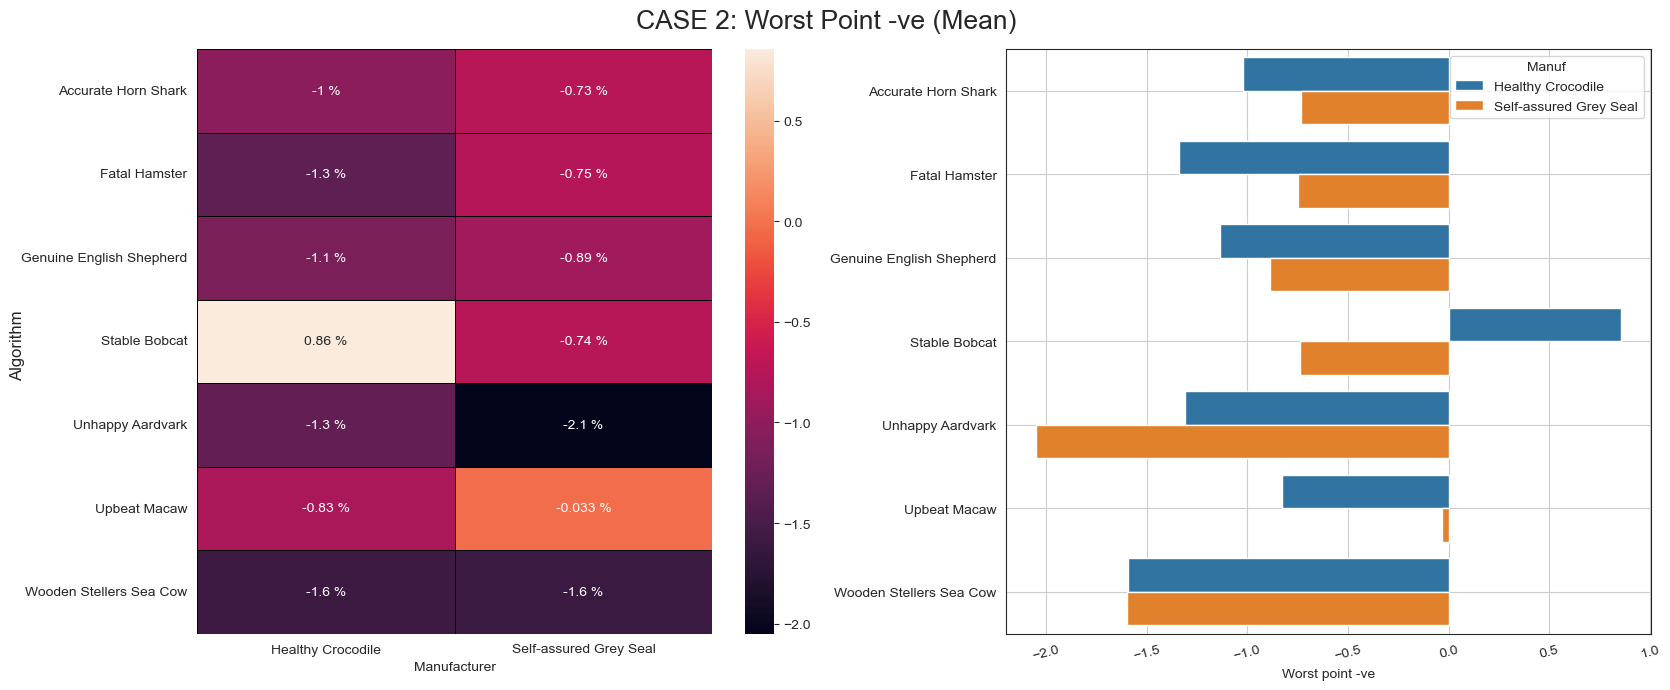

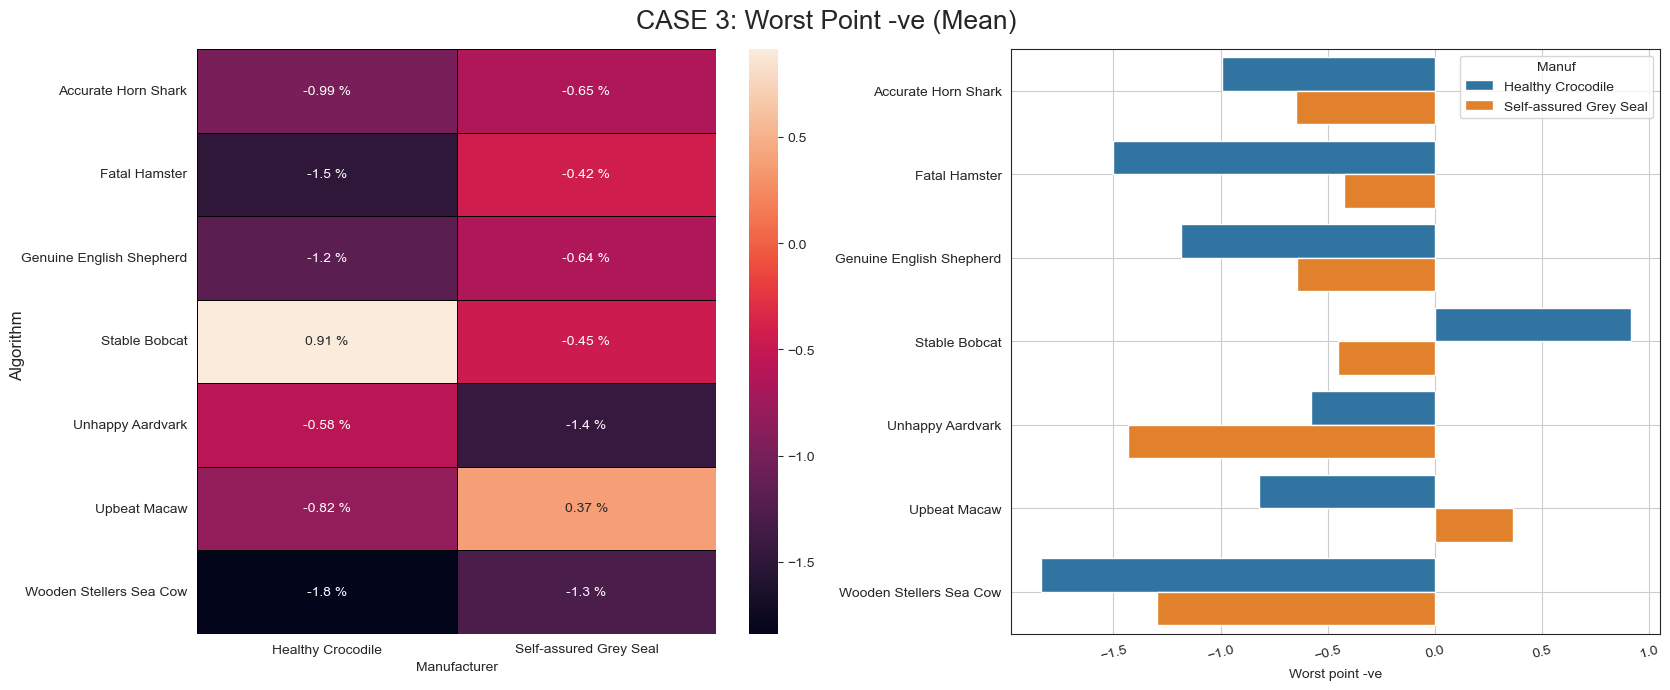

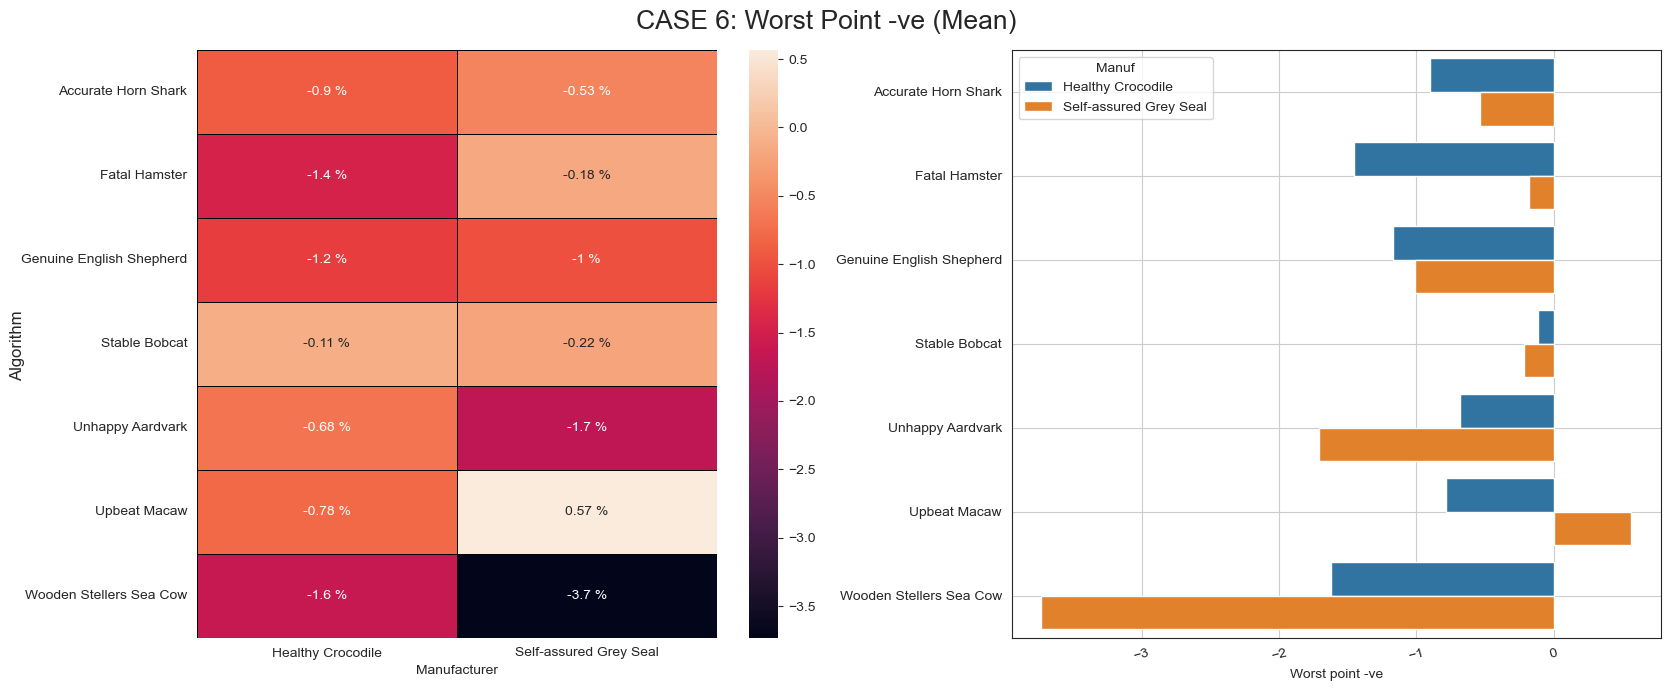

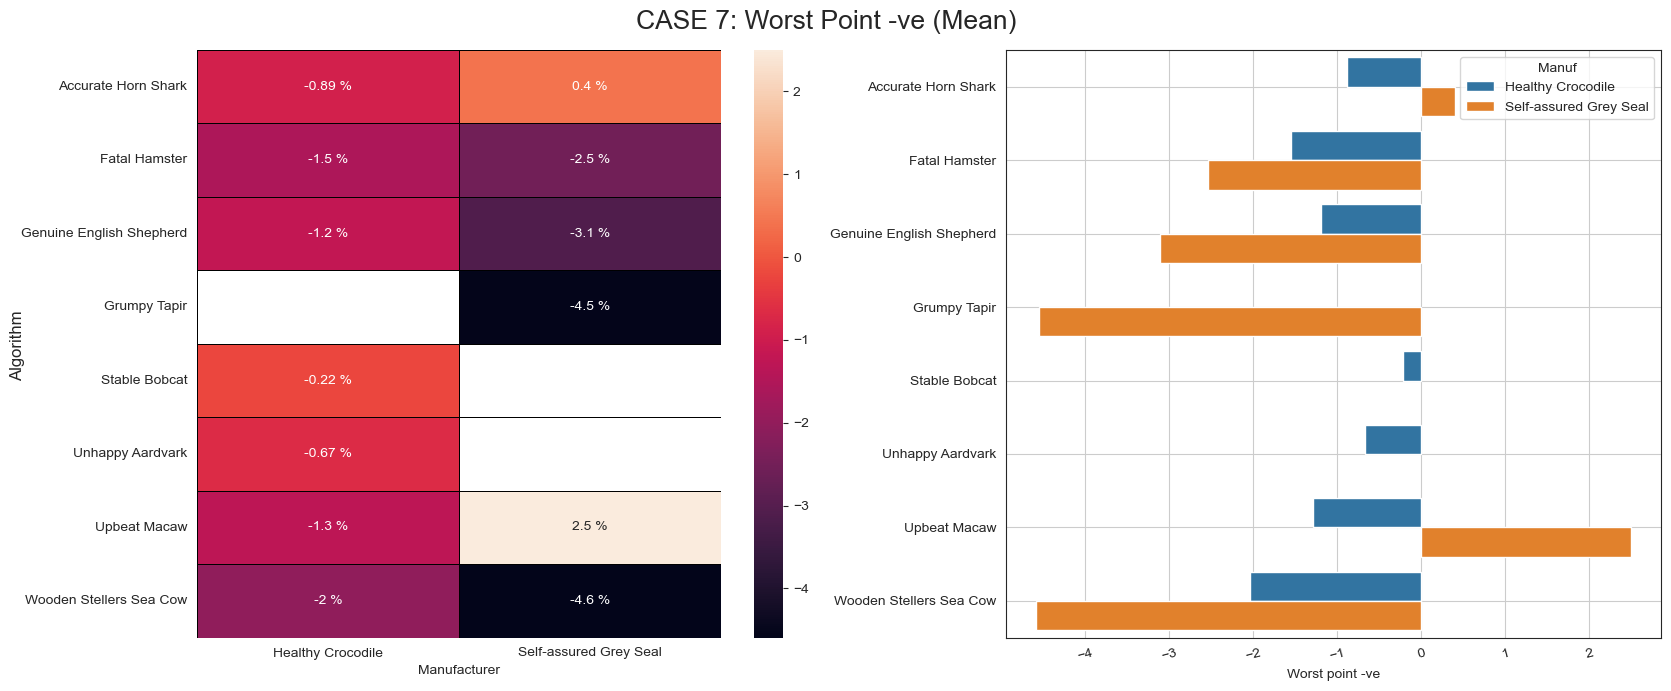

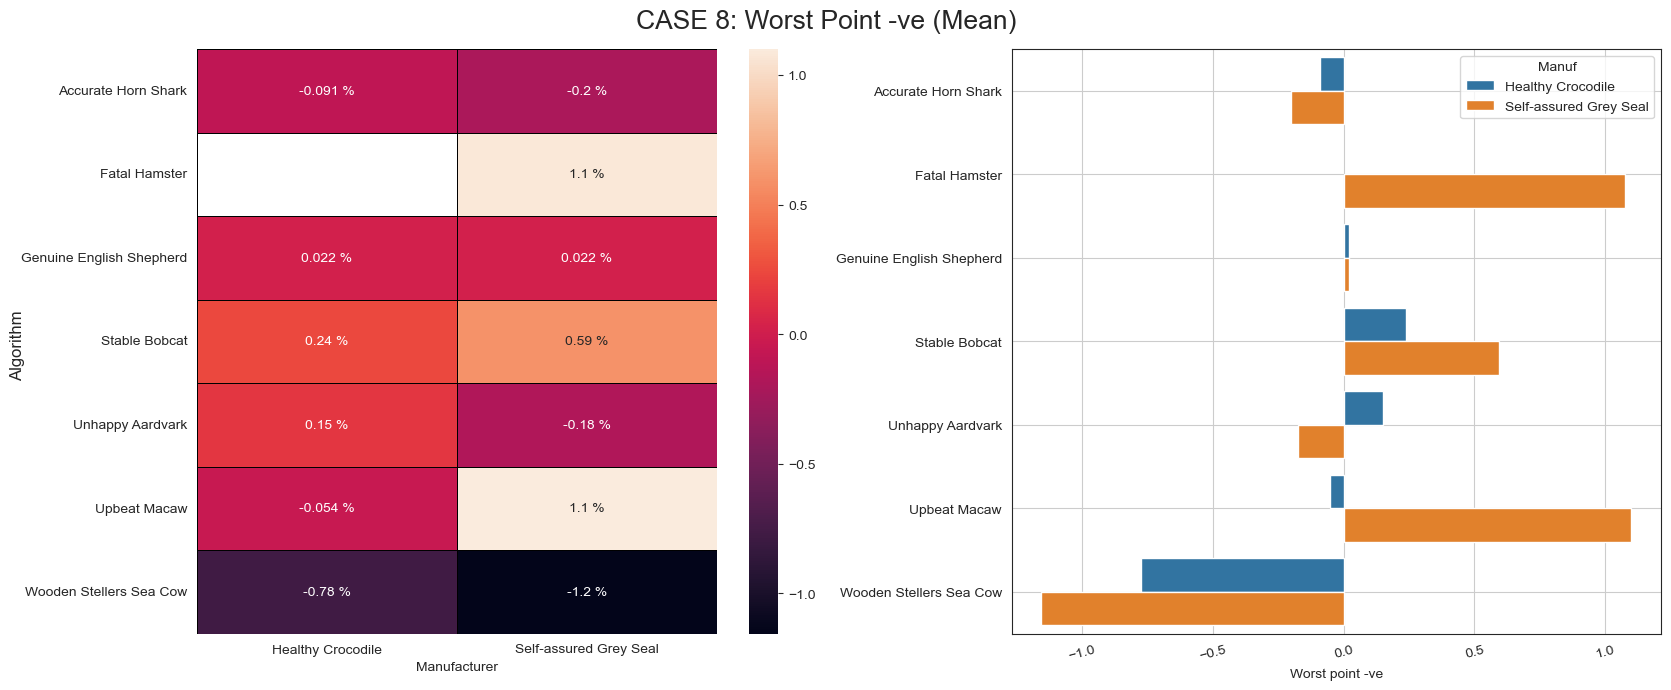

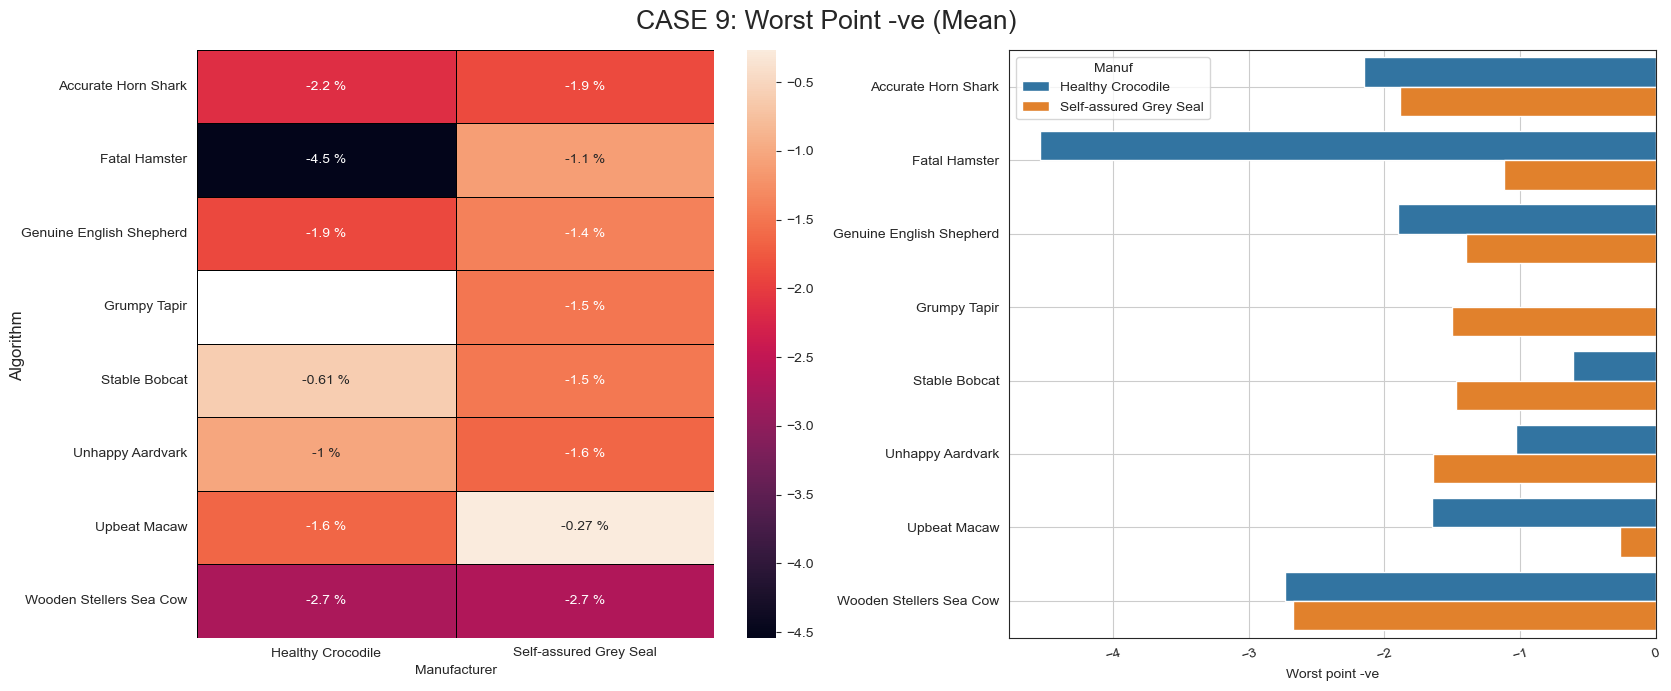

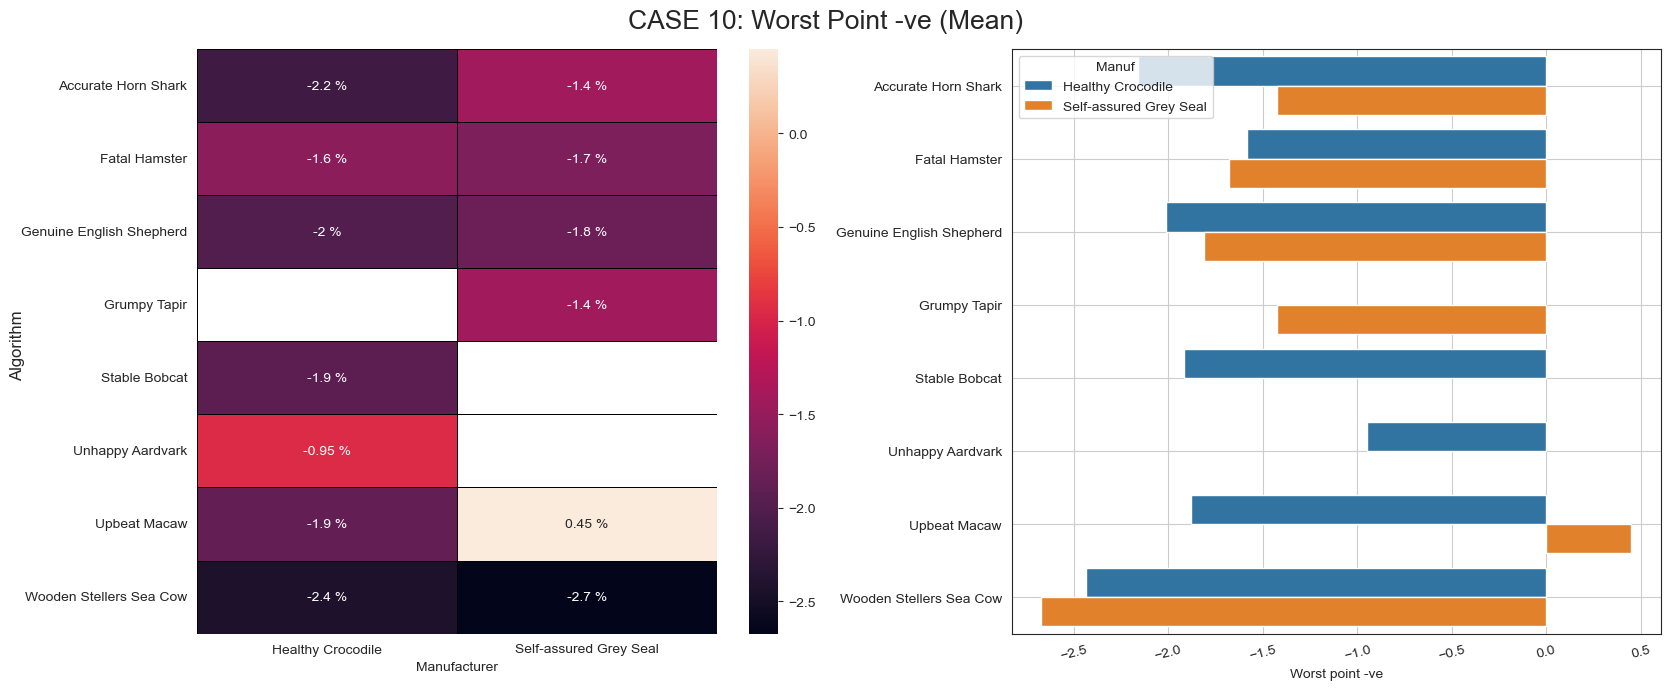

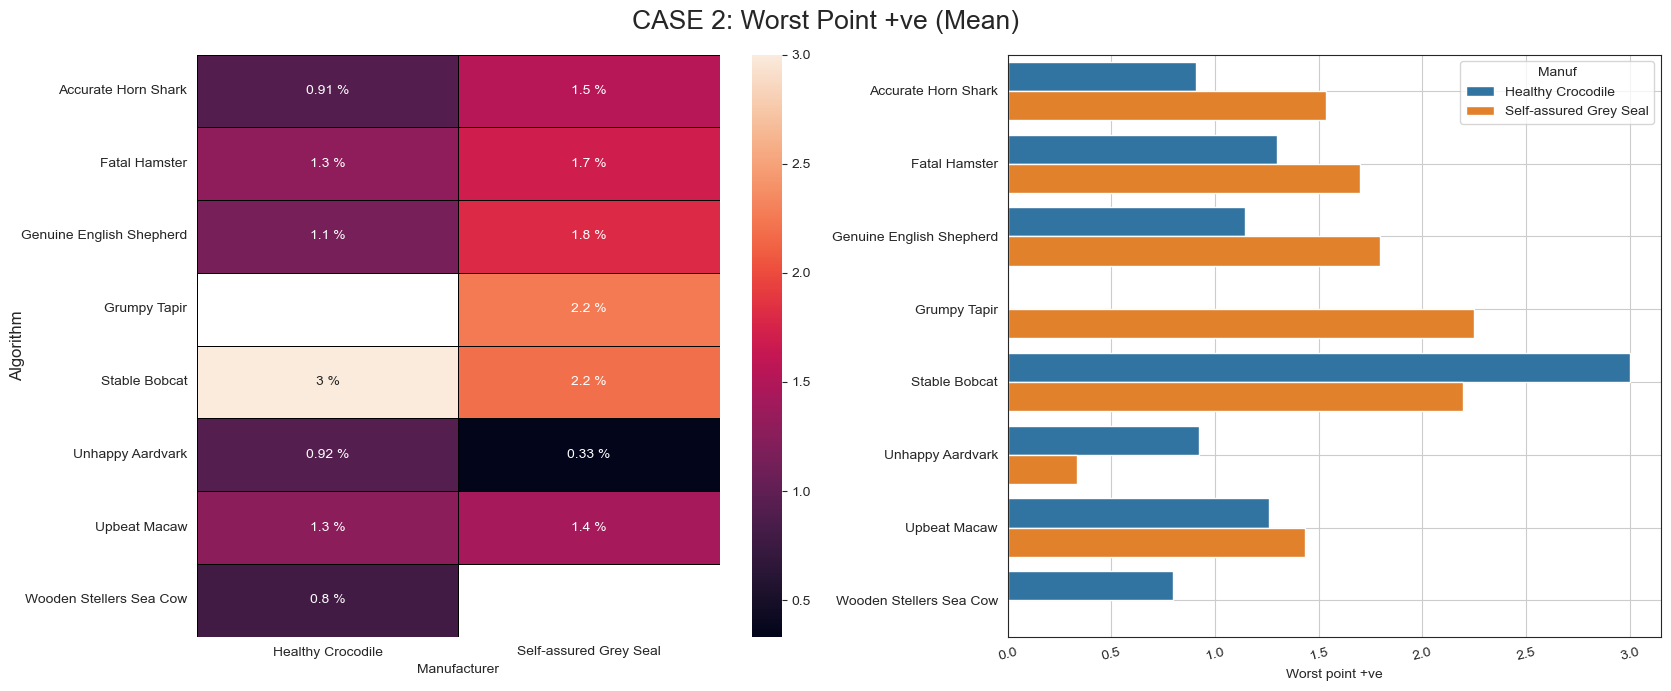

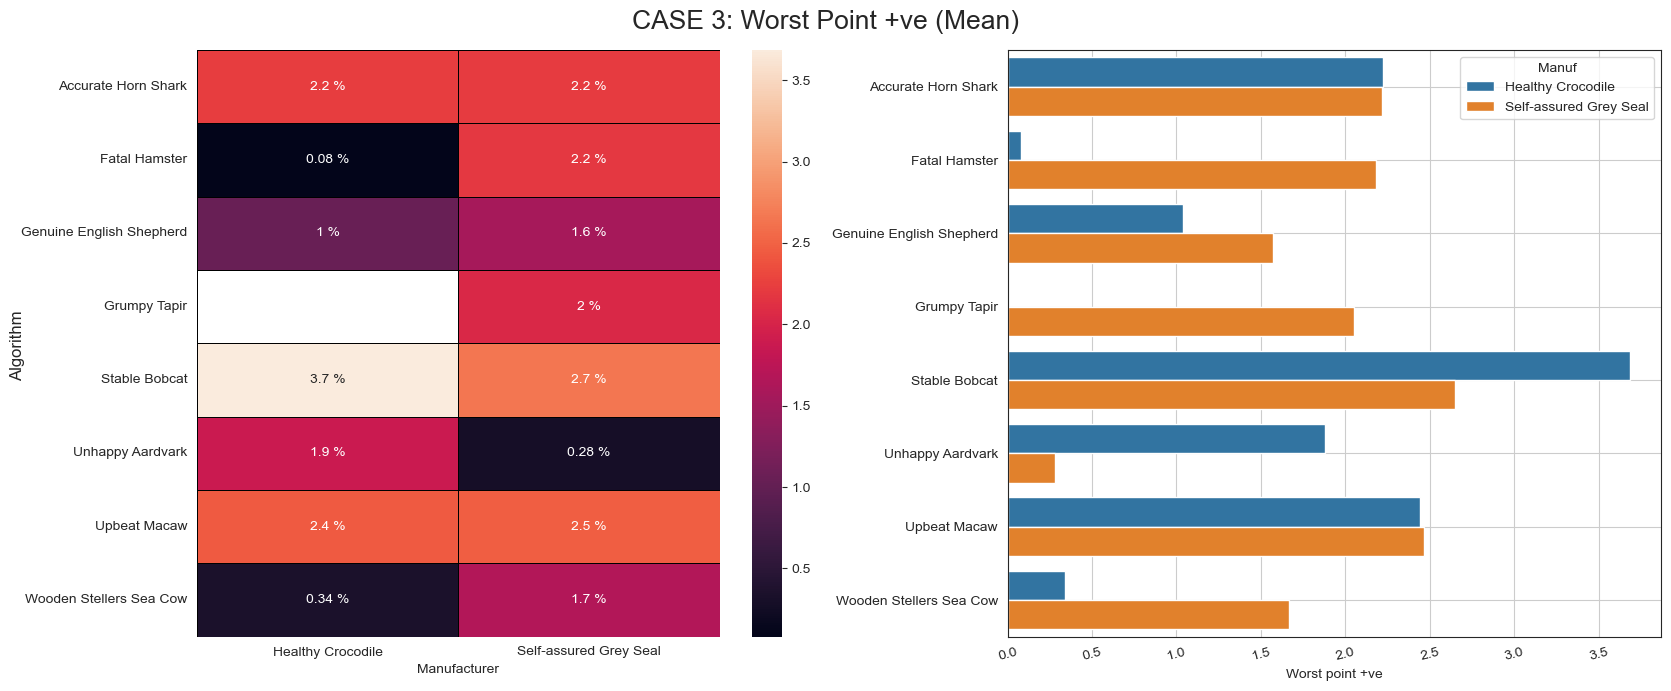

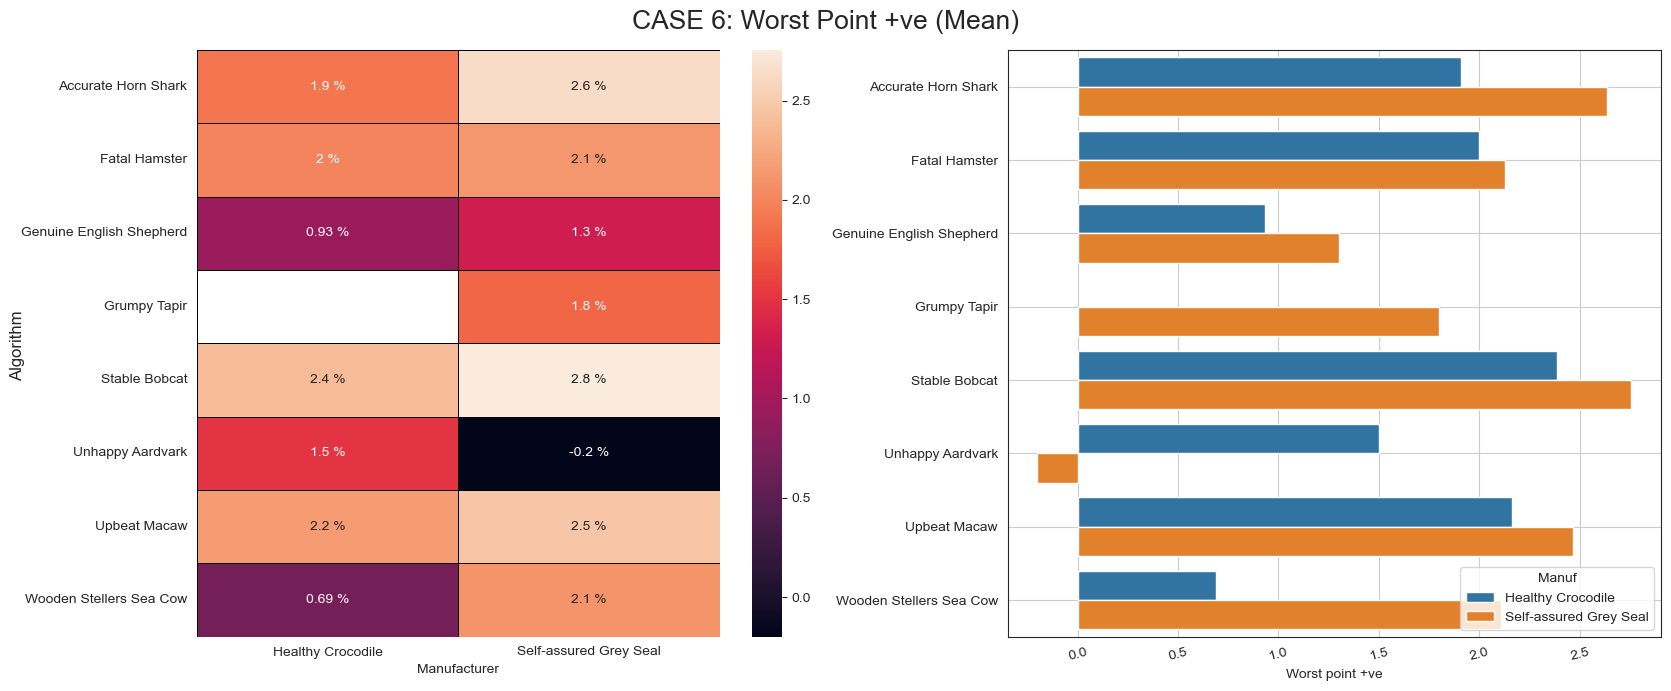

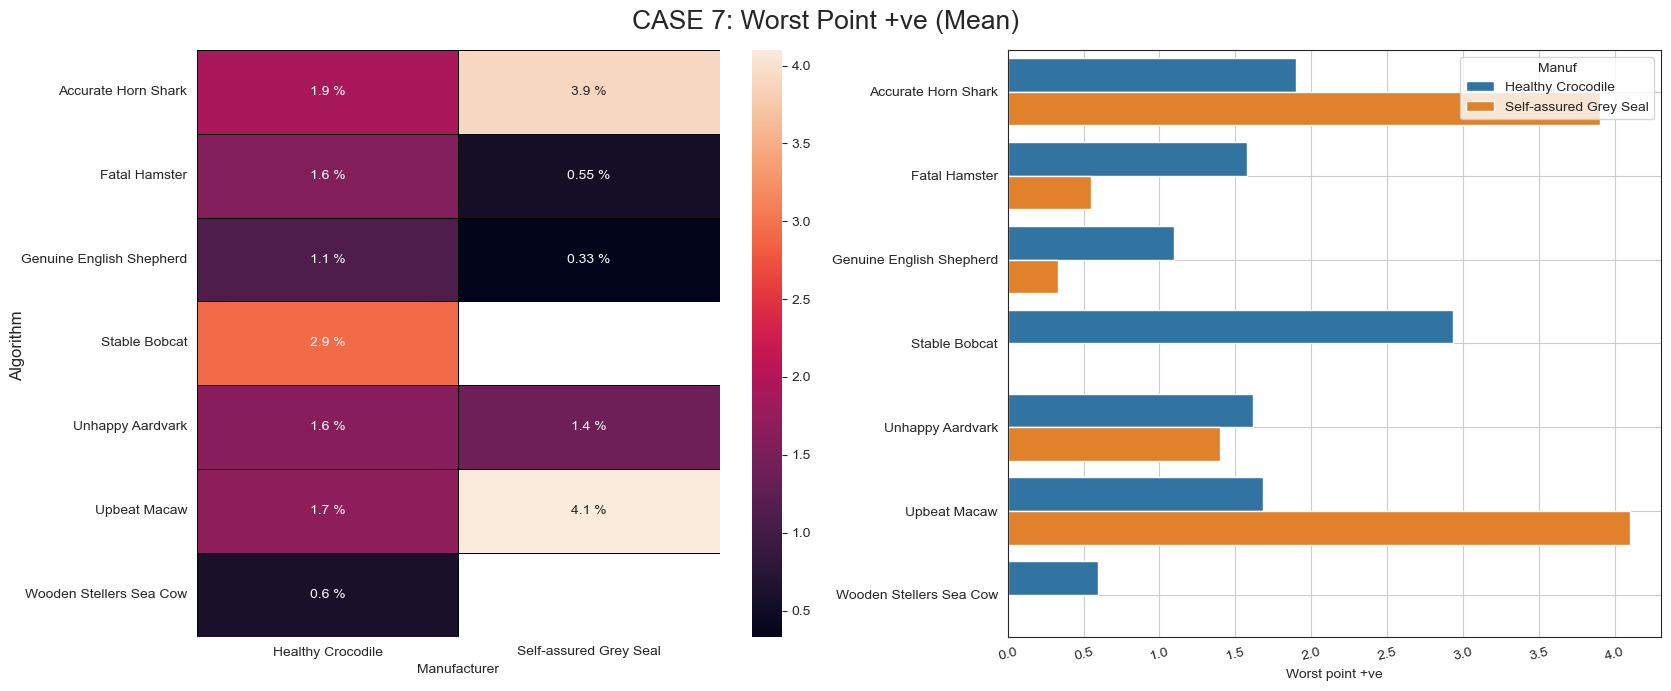

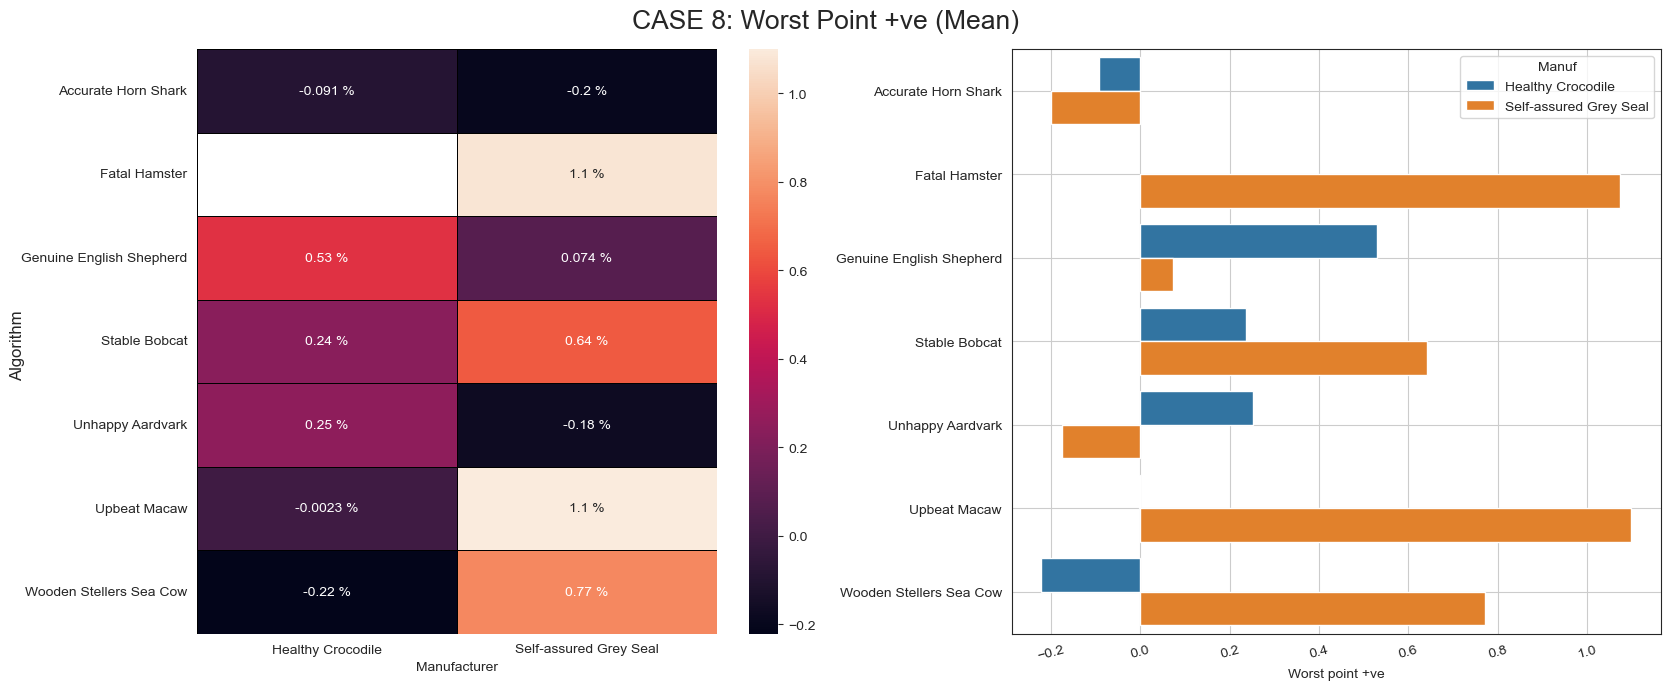

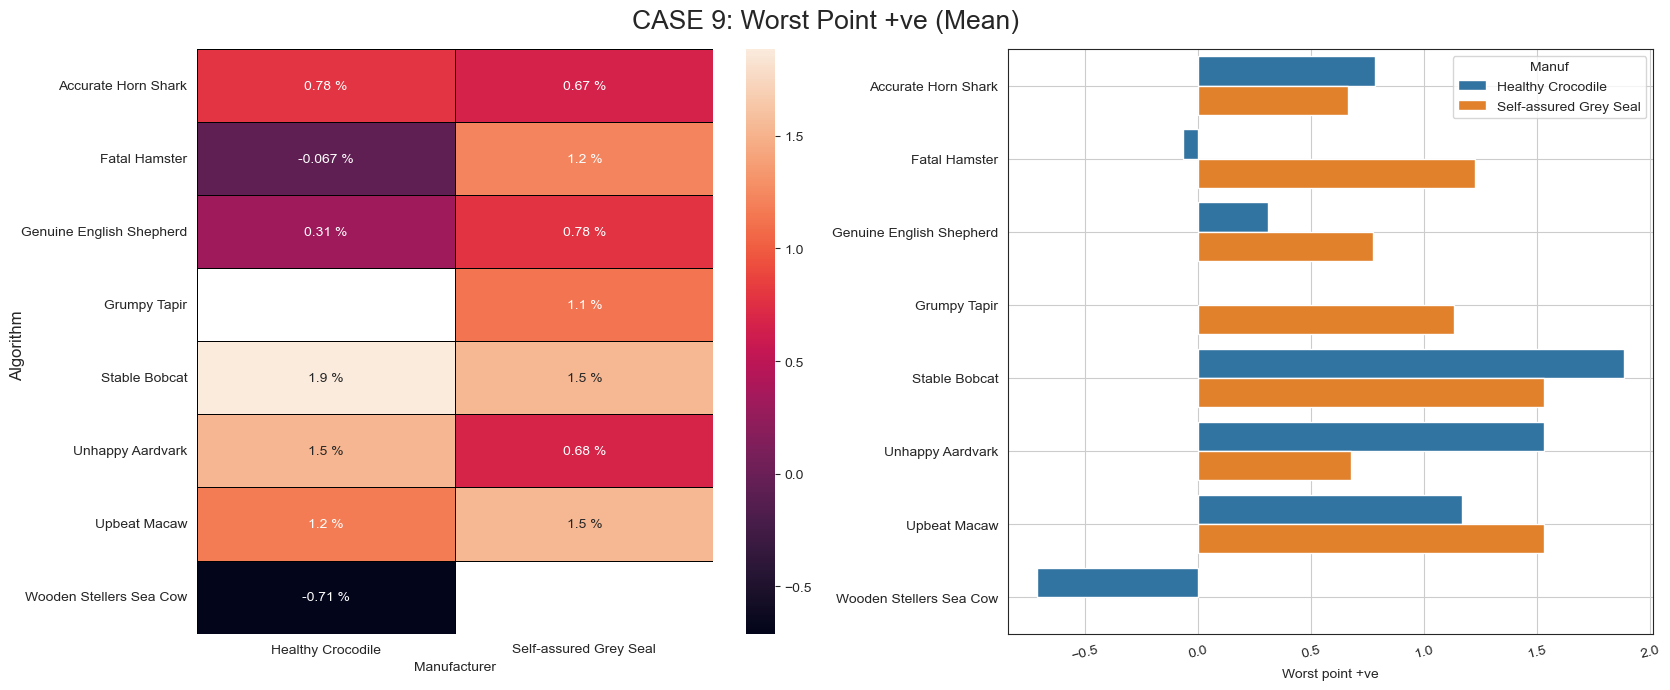

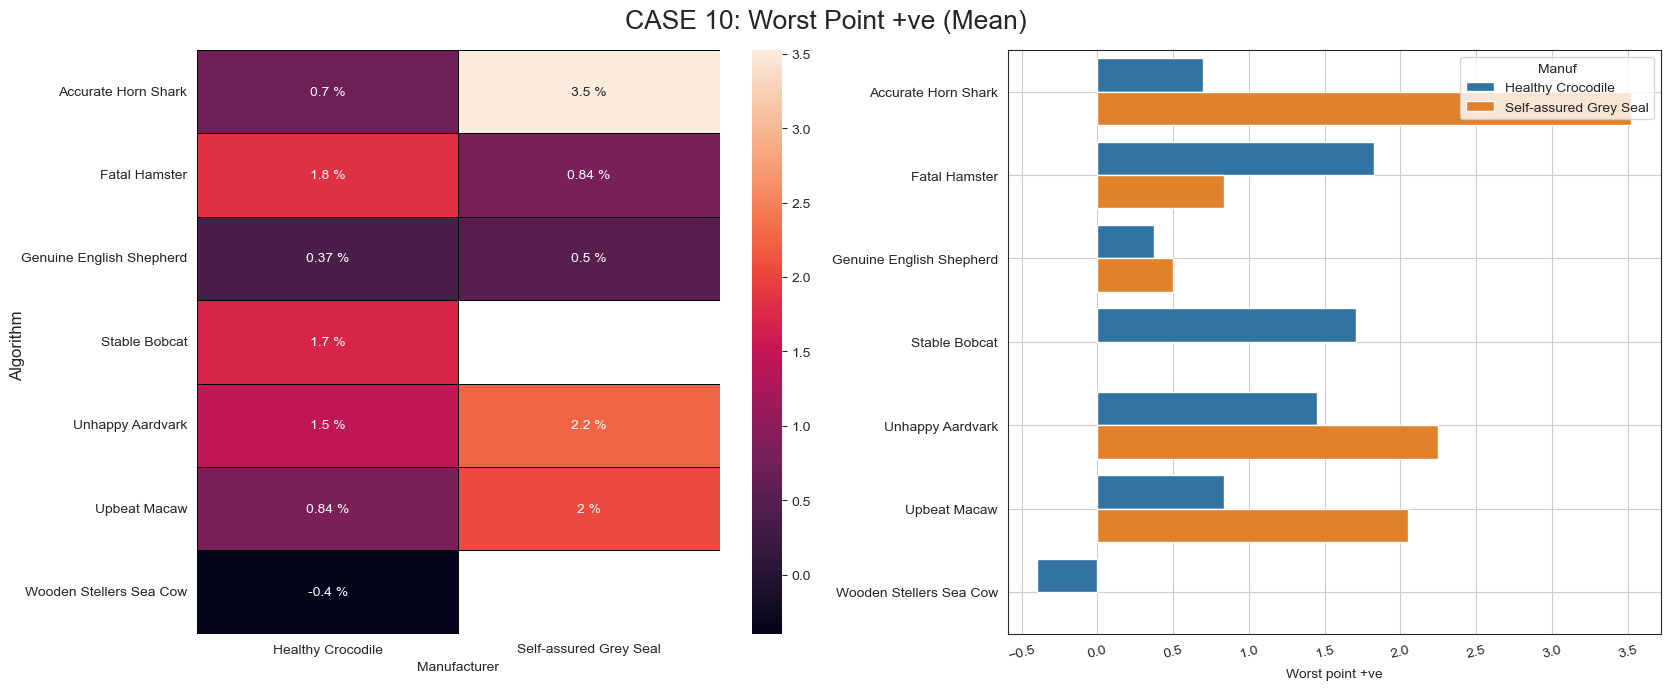

In [68]:
# For every point
import numpy as np
sns.set_style('white')
# sns.set_theme()

for point_type in data["point_type"].value_counts().keys():
    for case in cases:
        fig, (ax1,ax2) = plt.subplots(1,2, figsize = (17,7))
        file_path = "Cleansing the data/Datasets by Case/Case3_Corrected/case_" + str(case) + "_corrected.csv"
        df_caseX = pd.read_csv(file_path)
        df_caseX_pp = df_caseX[["manuf","algorithm","point_type","point_value"]][df_caseX["point_type"] == point_type]
        df_caseX_pp["point_value%"] = df_caseX_pp["point_value"] * 100
        
        pt = pd.pivot_table(df_caseX_pp,
                              index='algorithm',
                              columns='manuf', 
                              values='point_value%')
        #HEATMAP
        hmap = sns.heatmap(pt,
                          annot = True,
                          linewidths=0.5, 
                          linecolor='black',
                          ax = ax1)
        hmap.set_xlabel("Manufacturer")
        hmap.set_ylabel("")
        
        for t in hmap.texts: t.set_text(t.get_text() + " %")
        # hmap.set_title("CASE " + str(case) + ": " + str(point_type) + " (Mean)")
        
        #BARPLOT
        pt_reset = pt.stack().reset_index()
        bplot = sns.barplot(pt_reset,
                            y = 'algorithm',
                            x = pt_reset[0], 
                            hue = 'manuf', 
                            orient = 'h', 
                            ax = ax2)
        bplot.set_ylabel("")
        bplot.set_xlabel(str(point_type).capitalize())
        bplot.legend_.set_title("Manuf")
        bplot.legend_.get_draggable()
        
        fig.suptitle("CASE " + str(case) + ": " + str(point_type) + " (Mean)", size = 19)
        fig.supylabel("Algorithm")
        fig.tight_layout()
        plt.grid()
        
        path = "Figures/Algo_manuf_mean/"+str(point_type)+"/Case_" + str(case) + ".png"
        
        if not isfile(path):
            plt.savefig(path, bbox_inches='tight')
            print("Figure Saved!")
            
        plt.show()